In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gc


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow as tf


from sklearn.model_selection import train_test_split

import random
random.seed(42)

## Step 1: import masked specs. Reformat so they can be concatenated to training arrays.

In [2]:
masks_inpath = '../scratch_data/holdout/'
os.listdir(masks_inpath)

['holdout_1_neg.pkl', 'holdout_1_pos.pkl', 'positives', 'negatives']

In [3]:
mask_files = [i for i in os.listdir(masks_inpath) if 'holdout' in i]
mask_files

['holdout_1_neg.pkl', 'holdout_1_pos.pkl']

In [4]:
masks = []
labels = []
for i in mask_files:
    with open (masks_inpath + i, mode = 'rb') as m:
        temp = pickle.load(m)
    masks += temp
    if 'pos' in i:
        labels += [1]*len(temp)
    else:
        labels += [0]*len(temp)

In [5]:
masks[0].shape

(610, 368)

In [6]:
#standardize: standard scaler per individual array
masks = [(i-np.mean(i)) / np.std(i) for i in masks]

In [7]:
#shuffle
#zipping then unzipping - look I *know* random seed should make shuffling equal in both lists
#but without being able to easily check for confirmation it just feels risky, ya know?
zipped = list(zip(masks, labels))
random.shuffle(zipped)
masks, labels = zip(*zipped)

In [8]:
labels[0:10]  #confirm shuffled

(1, 0, 1, 0, 0, 0, 0, 1, 0, 1)

In creating the un-masked train-test-split groups, I already standardized each input array, cast as np.arrays, and shaped them as 4D tensors. Convenient to do all that preprocessing in one step at the time, but now it requires some reformatting on both sides so the masks can be added into the equation. Converting masks to array for reshaping, then back to list for concatenating with list(X_train). This avoids errors or anomolous fitting due to mixed value types.

In [9]:
#must be cast as array for reshape to join with X_train
masks = np.array(masks)
masks = masks.reshape(masks.shape[0], 610, 368, 1)

#must also list to concatenate to X_train, y_train
masks = list(masks)
labels = list(labels) #was tuple

## Step 2: Instantiate model, same as v4 which was trained with no masks

In [10]:
#v4 model params
cnn = Sequential()
cnn.add(Conv2D(filters = 8, 
               kernel_size=(11,11),
               strides = (4,4), #kernel_size and stride from AlexNet
               activation='relu', 
               input_shape=(610, 368, 1),
               padding = 'valid')) #no padding
cnn.add(MaxPooling2D(pool_size = (3,3), strides=(2,2)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(filters= 16, 
              kernel_size=(5,5), #LeNet uses 2xconv2d with 5x5 kernel, 2x2 pooling
              activation='relu')) #default strides =1
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
cnn.add(BatchNormalization())
        
cnn.add(Conv2D(filters = 16,
               kernel_size = (5,5),
               activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))  #output dim = 15 x 8 x 16 = 1920
cnn.add(BatchNormalization())

cnn.add(Flatten())

# 2 x hidden layers w dropout and weight decay
#input nodes = # features
cnn.add(Dense(1920, activation='relu', kernel_regularizer=l2(.001))) 
cnn.add(Dropout(.2)) #double regularization to mitigate overfitting
cnn.add(Dense(128, activation = 'relu', kernel_regularizer=l2(.001)))
cnn.add(Dropout(.2))
cnn.add(Dense(1, activation='sigmoid')) #output layer binary classification

In [11]:
#lower learning rate
slow_Adam = tf.keras.optimizers.Adam(learning_rate=.0001)

In [12]:
# compile model
cnn.compile(loss = 'binary_crossentropy', optimizer=slow_Adam, 
            metrics=['acc', 'Recall', 'Precision'])

In [13]:
#add earlystop?
early_stop = EarlyStopping(monitor='val_recall', patience = 5)

## Step 3: Fit with train-test splits, with masked spectrograms interspersed with training data
No masks in testing data

In [14]:
#import data, assign pos/neg
in_path = '../scratch_data/tts_chunked/'
os.listdir(in_path)

['ch5_test.pkl',
 'ch4_test.pkl',
 'ch7_train.pkl',
 'ch1_train.pkl',
 'ch6_train.pkl',
 'ch8_test.pkl',
 'ch2_test.pkl',
 'ch3_test.pkl',
 'ch0_train.pkl',
 'ch8_train.pkl',
 'ch5_train.pkl',
 'ch6_test.pkl',
 'ch7_test.pkl',
 'ch3_train.pkl',
 'ch1_test.pkl',
 'ch0_test.pkl',
 'ch4_train.pkl',
 'ch2_train.pkl']

In [15]:
#function to preprocess chunks

def pkl_to_CNN(train_file, test_file):
    with open (in_path+train_file, mode = 'rb') as f:
        temp_train = pickle.load(f)
    with open (in_path+test_file, mode = 'rb') as j:
        temp_test = pickle.load(j)
        
    X_train, y_train = list(zip(*temp_train))
    X_test, y_test = list(zip(*temp_test))

    # X_train, y_train as lists for upcoming addition of masks later
    return list(X_train), np.array(X_test), list(y_train), np.array(y_test)

In [16]:
histlist = []
count = 0
for i in range(0,9):
    
    X_train, X_test, y_train, y_test = pkl_to_CNN(f'ch{i}_train.pkl', f'ch{i}_test.pkl')

    #disperse masked spects among some training sets
    #append (masks, labels) to (X_train, y_train)
    if i%2==0:
        X_train = X_train + masks[count:count+int((len(masks)/4.9))]
        y_train = y_train + labels[count:count+int((len(labels)/4.9))]
        count += int(len(labels)/4.9)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_train = X_train.reshape(X_train.shape[0], 610, 368, 1) #k this one might be overkill
    
    else:
        X_train = np.array(X_train)
        y_train = np.array(y_train)
    
    history = cnn.fit(X_train, y_train,
                      batch_size=64,
                      validation_data = (X_test, y_test),
                      epochs = 300, 
                      callbacks = early_stop, verbose=1)
    histlist.append(history.history)
    
    if i<8:
        del X_train, X_test, y_train, y_test
        gc.collect()
    
    print(f'\n\n        chunk {i+1} of 9 fit\n\n')

Epoch 1/300
36/36 [==============================] - 23s 606ms/step - loss: 2.8211 - acc: 0.6648 - recall: 0.2843 - precision: 0.3742 - val_loss: 2.7291 - val_acc: 0.7600 - val_recall: 0.0833 - val_precision: 0.6500
Epoch 2/300
36/36 [==============================] - 21s 580ms/step - loss: 2.5874 - acc: 0.7971 - recall: 0.4229 - precision: 0.6793 - val_loss: 2.6908 - val_acc: 0.7632 - val_recall: 0.0513 - val_precision: 1.0000
Epoch 3/300
36/36 [==============================] - 21s 586ms/step - loss: 2.5650 - acc: 0.8150 - recall: 0.4568 - precision: 0.6887 - val_loss: 2.6806 - val_acc: 0.7616 - val_recall: 0.0449 - val_precision: 1.0000
Epoch 4/300
36/36 [==============================] - 22s 588ms/step - loss: 2.5817 - acc: 0.8113 - recall: 0.4376 - precision: 0.6964 - val_loss: 2.6774 - val_acc: 0.7600 - val_recall: 0.0449 - val_precision: 0.8750
Epoch 5/300
36/36 [==============================] - 22s 593ms/step - loss: 2.5718 - acc: 0.8061 - recall: 0.4013 - precision: 0.6761 - 

In [17]:
#eval on unseen test set to follow, but score for last chunk trained:
#predicted majority class the whole time, no convergence, HUGE loss holy heck
cnn_score = cnn.evaluate(X_test, y_test, verbose=1)

19/19 [==============================] - 0s 19ms/step - loss: 2.6786 - acc: 0.7776 - recall: 0.3673 - precision: 0.5870


In [18]:
num_epochs = [len(i['loss']) for i in histlist]
num_epochs #per subset

[8, 6, 6, 6, 8, 6, 6, 6, 6]

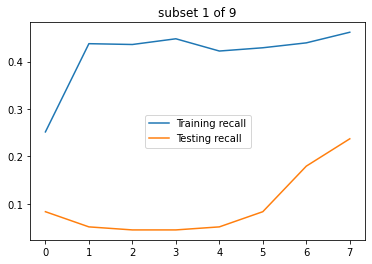

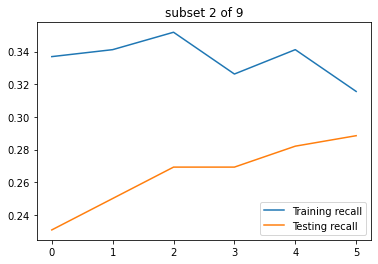

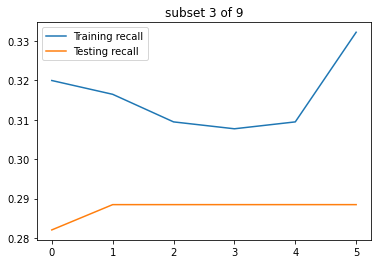

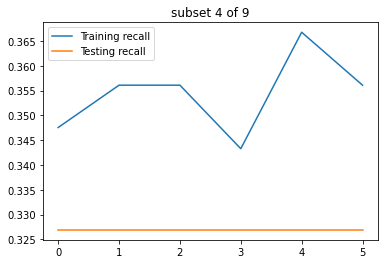

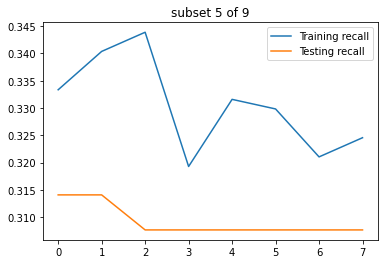

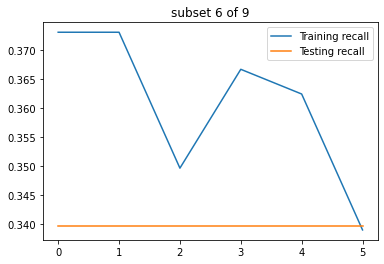

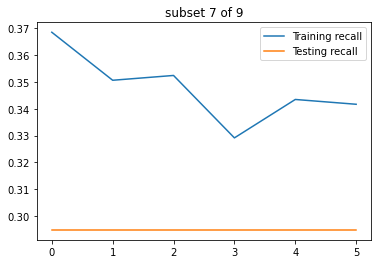

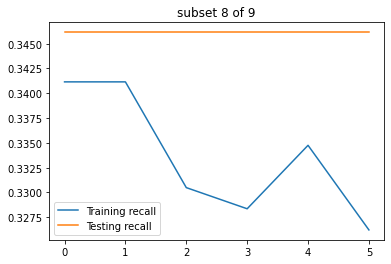

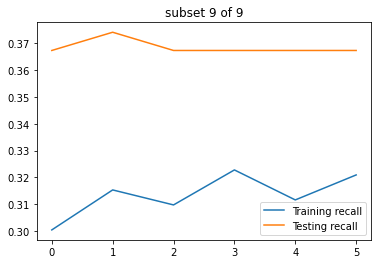

In [26]:
for i in range(len(histlist)):
    plt.figure()
    plt.plot(histlist[i]['recall'], label='Training recall')
    plt.plot(histlist[i]['val_recall'], label='Testing recall')
    plt.title(f'subset {i+1} of 9')
    plt.legend();

In [20]:
with open ('../data/models/v4_hist_cnn_masked.pkl', mode = 'wb') as f:
    pickle.dump(histlist, f)

In [21]:
import tensorflow
tensorflow.keras.models.save_model(cnn, '../data/models/v4_lg_masked')

/Users/helenmeigs/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/helenmeigs/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ../data/models/v4_lg_masked/assets
